In [34]:
#!pip install -r requirements.txt
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [35]:
f = "data/tcga_brca_all_clean.csv.zip"

#TODO slide_id -> file path 

## Preprocessing genomic data 

In [36]:
n_bins = 4
df = pd.read_csv(f,compression='zip')

df_uncensored = (df[df["censorship"]==0]).drop_duplicates(["case_id"])
_,bins = pd.qcut(df_uncensored['survival_months'],q = n_bins,retbins=True)  # distribute censored survival months into quartiles

# adapt bins 
bins[0] = 0 
bins[-1] = np.inf
#
labels=[i for i in range(n_bins)]
labels

df.insert(6,"survival_months_discretized",  pd.cut(df["survival_months"],
                                                               bins=bins, 
                                                               labels=labels)) # insert binned survival momnth 
k = 7
df.insert(3,"kfold",df.index%k) # insert kfold 
df.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'data/tcga_brca_all_clean.csv.zip'

scale genomic data first and store in DF again
then add labels to stratify 

In [ ]:
# todo add new column k-th-fold that contains an int in arange(k) where k is a cluster 
groundtruth = df["survival_months_discretized"]
censorship = df["censorship"]
genomics = df[df.keys()[11:]]
genomics


,NOTCH2_cnv,ACP6_cnv,ANKRD20A12P_cnv,ANKRD34A_cnv,ANKRD35_cnv,BCL9_cnv,BOLA1_cnv,CD160_cnv,CHD1L_cnv,FAM72B_cnv,...,ZWINT_rnaseq,ZXDA_rnaseq,ZXDB_rnaseq,ZXDC_rnaseq,ZYG11A_rnaseq,ZYG11B_rnaseq,ZYX_rnaseq,ZZEF1_rnaseq,ZZZ3_rnaseq,TPTEP1_rnaseq
403,1,1,1,1,1,1,1,1,1,1,...,-0.6752,-0.6708,-0.6352,0.3693,0.1446,3.2597,-0.1603,-0.8919,0.5903,-0.0801
598,0,0,0,0,0,0,0,0,0,0,...,-0.0525,-0.2132,-0.2256,0.1374,0.5972,-0.7959,-1.1744,-0.3666,-1.3888,-0.7535
817,0,0,0,0,0,0,0,0,0,0,...,0.3245,-0.3567,1.7451,-0.5448,1.7019,-0.6458,2.4399,0.7366,-0.3115,0.9021
244,0,0,0,0,0,0,0,0,0,0,...,-0.9956,-0.5694,-0.7817,0.0144,-0.9142,-1.2975,3.6863,0.0938,-0.0315,0.0677
320,1,1,1,1,1,1,1,1,1,1,...,1.2331,0.9744,-0.6189,-2.1771,1.8906,-0.3966,-0.0656,-1.6399,-0.5391,-0.6042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,1,1,1,1,1,1,1,1,1,1,...,-0.2865,-0.7057,-0.8934,0.2821,-0.1644,-1.1582,0.1480,0.0373,-0.6824,-0.5994
72,1,1,1,1,1,1,1,1,1,1,...,-0.2171,0.1621,-0.3724,1.5166,0.5926,1.0383,0.0326,-0.1507,0.2853,-0.3509
908,0,0,0,0,0,0,0,0,0,0,...,-0.5362,0.3350,0.2731,1.8174,0.8894,0.7809,-0.6663,-0.3758,0.2849,-0.6437
235,1,1,1,1,1,1,1,1,1,1,...,-0.9187,0.9464,0.0057,0.2020,0.0415,-0.1023,0.4811,0.3689,0.0824,-0.4666


In [ ]:


scaler = StandardScaler()
scaled_genomics = scaler.fit_transform(genomics)
#scaler.inverse_transform(scaled_genomics)
df_scaled = df.copy()
df_scaled[df.keys()[11:]] = scaled_genomics



###  This leads to the full function:

In [ ]:
def clean2trainable(df_path,k,n_bins=4,savename = None):
    df = pd.read_csv(df_path,compression='zip')

    # get time bins 
    df_uncensored = (df[df["censorship"]==0]).drop_duplicates(["case_id"])
    _,bins = pd.qcut(df_uncensored['survival_months'],q = n_bins,retbins=True)  # distribute censored survival months into quartiles

    # adapt time bins 
    bins[0] = 0 
    bins[-1] = np.inf
    # bin name = index 
    labels = [i for i in range(n_bins)]
    df.insert(6,"survival_months_discretized",  pd.cut(df["survival_months"],
                                                               bins=bins, 
                                                               labels=labels)) # insert binned survival month 
    df.insert(3,"kfold",df.index%k) # insert kfold 

    genomics = df[df.keys()[11:]]

    scaler = StandardScaler()
    scaled_genomics = scaler.fit_transform(genomics)
    df[df.keys()[11:]] = scaled_genomics

    if savename is not None:
        df.to_csv(savename,index=False)
    return df 

In [ ]:
f = "data/tcga_brca_all_clean.csv.zip"
new_df = clean2trainable(f,5,4,savename = "./data/tcga_brca_trainable.csv")
#new_df = clean2trainable(f,7,4)

In [ ]:
f_new = "data/tcga_brca_trainable.csv"
df = pd.read_csv(f_new)
df.head()

,case_id,slide_id,site,kfold,is_female,oncotree_code,age,survival_months_discretized,survival_months,censorship,...,ZWINT_rnaseq,ZXDA_rnaseq,ZXDB_rnaseq,ZXDC_rnaseq,ZYG11A_rnaseq,ZYG11B_rnaseq,ZYX_rnaseq,ZZEF1_rnaseq,ZZZ3_rnaseq,TPTEP1_rnaseq
0,TCGA-3C-AALI,TCGA-3C-AALI-01Z-00-DX1.F6E9A5DF-D8FB-45CF-B4B...,3C,0,1.0,IDC,50.0,3,131.57,1.0,...,0.153655,-0.207313,-0.427975,0.825128,0.825317,-0.963470,0.880672,0.164444,-1.064402,2.395788
1,TCGA-3C-AALI,TCGA-3C-AALI-01Z-00-DX2.CF4496E0-AB52-4F3E-BDF...,3C,1,1.0,IDC,50.0,3,131.57,1.0,...,0.153655,-0.207313,-0.427975,0.825128,0.825317,-0.963470,0.880672,0.164444,-1.064402,2.395788
2,TCGA-3C-AALJ,TCGA-3C-AALJ-01Z-00-DX1.777C0957-255A-42F0-9EE...,3C,2,1.0,IDC,62.0,2,48.42,1.0,...,2.665836,-1.099110,-0.184212,-1.279398,2.112450,-1.190473,0.856429,-0.579342,-0.874345,-0.485389
3,TCGA-3C-AALJ,TCGA-3C-AALJ-01Z-00-DX2.62DFE56B-B84C-40F9-962...,3C,3,1.0,IDC,62.0,2,48.42,1.0,...,2.665836,-1.099110,-0.184212,-1.279398,2.112450,-1.190473,0.856429,-0.579342,-0.874345,-0.485389
4,TCGA-3C-AALK,TCGA-3C-AALK-01Z-00-DX1.4E6EB156-BB19-410F-878...,3C,4,1.0,IDC,52.0,2,47.57,1.0,...,-0.322065,-0.381861,-0.459009,-0.931029,0.602789,-0.951448,0.979160,-0.899523,-0.520568,-0.384345


In [ ]:
df[df.keys()[11:]].head()

,NOTCH2_cnv,ACP6_cnv,ANKRD20A12P_cnv,ANKRD34A_cnv,ANKRD35_cnv,BCL9_cnv,BOLA1_cnv,CD160_cnv,CHD1L_cnv,FAM72B_cnv,...,ZWINT_rnaseq,ZXDA_rnaseq,ZXDB_rnaseq,ZXDC_rnaseq,ZYG11A_rnaseq,ZYG11B_rnaseq,ZYX_rnaseq,ZZEF1_rnaseq,ZZZ3_rnaseq,TPTEP1_rnaseq
0,-2.117218,-2.241841,-2.241841,-2.241841,-2.241841,-2.241841,-2.241841,-2.241841,-2.241841,-2.241841,...,0.153655,-0.207313,-0.427975,0.825128,0.825317,-0.963470,0.880672,0.164444,-1.064402,2.395788
1,-2.117218,-2.241841,-2.241841,-2.241841,-2.241841,-2.241841,-2.241841,-2.241841,-2.241841,-2.241841,...,0.153655,-0.207313,-0.427975,0.825128,0.825317,-0.963470,0.880672,0.164444,-1.064402,2.395788
2,-0.863795,-0.929074,-0.929074,-0.929074,-0.929074,-0.929074,-0.929074,-0.929074,-0.929074,-0.929074,...,2.665836,-1.099110,-0.184212,-1.279398,2.112450,-1.190473,0.856429,-0.579342,-0.874345,-0.485389
3,-0.863795,-0.929074,-0.929074,-0.929074,-0.929074,-0.929074,-0.929074,-0.929074,-0.929074,-0.929074,...,2.665836,-1.099110,-0.184212,-1.279398,2.112450,-1.190473,0.856429,-0.579342,-0.874345,-0.485389
4,-0.863795,-0.929074,-0.929074,-0.929074,-0.929074,-0.929074,-0.929074,-0.929074,-0.929074,-0.929074,...,-0.322065,-0.381861,-0.459009,-0.931029,0.602789,-0.951448,0.979160,-0.899523,-0.520568,-0.384345


## k-Fold crossvalidation
1. Cluster dataset into k groups (shuffle first(seeded) then stratify by patient,split into equal chunks)
2. use one group for testing and the others for training
3. rotate such that each group is once used for testing
4. use distribution of testing results to estimate real value 



In [ ]:
k = 7 
a = np.arange(k) # df k-th fold 
for i in range(k):  
    a = (a+1)%k
    print(f"train on {a[:-1]} test on {a[-1]}, store results in foldername: experiment1_fold{a[-1]}")



train on [1 2 3 4 5 6] test on 0, store results in foldername: experiment1_fold0
train on [2 3 4 5 6 0] test on 1, store results in foldername: experiment1_fold1
train on [3 4 5 6 0 1] test on 2, store results in foldername: experiment1_fold2
train on [4 5 6 0 1 2] test on 3, store results in foldername: experiment1_fold3
train on [5 6 0 1 2 3] test on 4, store results in foldername: experiment1_fold4
train on [6 0 1 2 3 4] test on 5, store results in foldername: experiment1_fold5
train on [0 1 2 3 4 5] test on 6, store results in foldername: experiment1_fold6


In [ ]:
df = pd.DataFrame({"col1": np.arange(100),"col2":np.random.rand(100)})
df
df["col1"] = df["col1"].apply(lambda x: f"thisis{x}")
df

,col1,col2
0,thisis0,0.771627
1,thisis1,0.445847
2,thisis2,0.593957
3,thisis3,0.457410
4,thisis4,0.182458
...,...,...
95,thisis95,0.087985
96,thisis96,0.931732
97,thisis97,0.929314
98,thisis98,0.755483


In [ ]:
f = "data/tcga_brca_all_clean.csv.zip"
f = f.replace("all_clean.csv.zip","trainable.csv")
f

'data/tcga_brca_trainable.csv'

In [ ]:
!pip install torchmetrics


  Using cached torchmetrics-0.11.4-py3-none-any.whl (519 kB)

[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import torch 
idx = torch.randint(low=0,high=4,size=(100,))
values = torch.zeros(size=(100,4))
source = torch.ones(size=(100,))

In [ ]:
values.scatter_(dim=1,index=idx,src=source)

RuntimeError: Index tensor must have the same number of dimensions as self tensor

In [ ]:
groundtruth = torch.zeros(size=(10,4))
a,b = groundtruth.size()
labels = torch.randint(low=0,high=b,size=(1,a))
groundtruth[torch.arange(a),labels]=1
groundtruth

tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]])

In [ ]:
from torchmetrics import Accuracy
acc = Accuracy("multiclass")

tensor([[1, 1, 1, 0, 0, 1, 2, 2, 3, 3]])

In [ ]:
a = torch.randint(low=0,high=2,size=(100,))
a



tensor([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 1])

In [ ]:

from sksurv.metrics import concordance_index_censored
c = torch.randint(0,2,size=(100,))
l = torch.randint(0,4,size=(100,))
out = nn.Sigmoid()(torch.rand(size=(100,4)))
c_index = concordance_index_censored(c,l,out)


ValueError: Expected 1D array, got 2D array instead:
array=[[0.7033437  0.5068377  0.654999   0.5990905 ]
 [0.7150219  0.599375   0.7102213  0.669106  ]
 [0.64452285 0.5671275  0.71529394 0.6757698 ]
 [0.6388677  0.62970865 0.64201355 0.5307401 ]
 [0.60350907 0.72728115 0.53220797 0.518223  ]
 [0.68350834 0.6934904  0.5089255  0.61560374]
 [0.67109674 0.6994699  0.6647645  0.52406156]
 [0.55831575 0.64931524 0.5347419  0.65587   ]
 [0.52917504 0.6606084  0.55667764 0.65744233]
 [0.7292093  0.56855935 0.7007709  0.66647863]
 [0.6349134  0.6343174  0.57802343 0.67564833]
 [0.6474086  0.58789873 0.6473337  0.5406985 ]
 [0.6528097  0.55204225 0.5219494  0.588915  ]
 [0.5066584  0.575144   0.62465805 0.5473152 ]
 [0.6980143  0.5550397  0.69929653 0.67663085]
 [0.66518444 0.5020233  0.54762226 0.68529356]
 [0.61191684 0.57054913 0.51956755 0.5036999 ]
 [0.5990251  0.6647159  0.5022067  0.6415785 ]
 [0.5096261  0.5296232  0.64971465 0.5950778 ]
 [0.7218662  0.65232795 0.5983458  0.6257463 ]
 [0.65301895 0.6039311  0.57282114 0.64343935]
 [0.70950943 0.5643408  0.71161604 0.5036222 ]
 [0.56625646 0.509335   0.5792254  0.61572915]
 [0.62246877 0.59285855 0.5865239  0.6409882 ]
 [0.5512244  0.5397312  0.58580446 0.594414  ]
 [0.6483152  0.6868134  0.65667236 0.5230461 ]
 [0.5616211  0.698877   0.63359326 0.728736  ]
 [0.6529768  0.6710834  0.666662   0.52926576]
 [0.5455406  0.5901774  0.5039173  0.50229514]
 [0.6278486  0.72436374 0.6860912  0.6959076 ]
 [0.50597304 0.713814   0.6326286  0.6273644 ]
 [0.65662265 0.5647073  0.58616865 0.646891  ]
 [0.6678679  0.55246246 0.5616041  0.71274585]
 [0.5203591  0.5386698  0.64613324 0.61203194]
 [0.68008655 0.6873198  0.71844333 0.6257025 ]
 [0.7298277  0.67418826 0.5938301  0.66317636]
 [0.67543834 0.5023487  0.6053202  0.6490979 ]
 [0.67269105 0.6210878  0.71898174 0.66912603]
 [0.70456284 0.71981895 0.66602397 0.64326096]
 [0.60190856 0.51107204 0.5898658  0.61134875]
 [0.59263074 0.5784401  0.54741335 0.5614796 ]
 [0.5989356  0.55273384 0.5732944  0.71651936]
 [0.5913896  0.54938984 0.60361534 0.53534436]
 [0.5141062  0.6119989  0.54016924 0.6341148 ]
 [0.71425146 0.6726476  0.58939916 0.7245826 ]
 [0.5873254  0.59445065 0.58369744 0.5891026 ]
 [0.5968411  0.64003295 0.6959099  0.6444287 ]
 [0.5450495  0.53397685 0.62487507 0.5077089 ]
 [0.5835435  0.6215533  0.57735515 0.642489  ]
 [0.557307   0.56761986 0.70220196 0.51394594]
 [0.5159483  0.7038531  0.6261901  0.63434386]
 [0.72761047 0.6025582  0.70891714 0.61075985]
 [0.5199391  0.50275004 0.59646523 0.66402894]
 [0.6963825  0.5442542  0.567837   0.70562667]
 [0.6432466  0.62537783 0.63242483 0.57596123]
 [0.5894853  0.66055566 0.65344256 0.5931886 ]
 [0.7301526  0.50607795 0.5494923  0.6291933 ]
 [0.7089705  0.6961766  0.5586037  0.5976287 ]
 [0.6130313  0.5604356  0.5972878  0.68639934]
 [0.51664704 0.68900746 0.68184733 0.53696966]
 [0.5886826  0.55988073 0.70646673 0.70089626]
 [0.54090255 0.7026498  0.55707085 0.54038   ]
 [0.5840731  0.67154956 0.5217902  0.5183401 ]
 [0.65526056 0.7000793  0.6698624  0.5305141 ]
 [0.63102967 0.60221153 0.55749315 0.59235895]
 [0.608334   0.707181   0.507087   0.6083674 ]
 [0.515192   0.5415555  0.5845034  0.582528  ]
 [0.62123877 0.5697925  0.5561974  0.5007077 ]
 [0.61007625 0.70058566 0.62560135 0.6279507 ]
 [0.7283216  0.56833994 0.72932595 0.59095794]
 [0.68331707 0.66165876 0.61356664 0.5835217 ]
 [0.5145504  0.5252778  0.6049514  0.53632414]
 [0.5843128  0.51487863 0.541528   0.6749439 ]
 [0.651314   0.525107   0.530047   0.57662064]
 [0.5899187  0.72903425 0.58088046 0.56718   ]
 [0.59032536 0.6409243  0.52353984 0.65532184]
 [0.6856491  0.5704291  0.6997388  0.5607072 ]
 [0.5616982  0.56394184 0.7009696  0.58921385]
 [0.6050089  0.65880936 0.7154291  0.72521573]
 [0.6253197  0.6155239  0.6816433  0.6848565 ]
 [0.5421478  0.5141121  0.6021258  0.58528125]
 [0.5093989  0.56185734 0.6934937  0.6141861 ]
 [0.626201   0.6440658  0.5739234  0.58163154]
 [0.516708   0.5852681  0.54061425 0.6389016 ]
 [0.60063165 0.71721005 0.6172488  0.5289654 ]
 [0.69206935 0.68975365 0.54912287 0.6318212 ]
 [0.5011444  0.61085147 0.69184405 0.5598021 ]
 [0.73076046 0.61929005 0.6955243  0.5656313 ]
 [0.69410634 0.72007406 0.5879938  0.6407076 ]
 [0.6469488  0.60425884 0.5105472  0.5041881 ]
 [0.69766206 0.6466432  0.6021804  0.5660987 ]
 [0.69878095 0.59292924 0.67088234 0.52607673]
 [0.6836516  0.6855315  0.54005367 0.52829343]
 [0.7178681  0.6848087  0.65245676 0.609253  ]
 [0.5492158  0.55435956 0.56264997 0.5188395 ]
 [0.63143706 0.6213038  0.5782583  0.69672054]
 [0.5931135  0.51481485 0.5317573  0.6294442 ]
 [0.6040276  0.5475191  0.65634286 0.6323826 ]
 [0.6253122  0.66581166 0.5658497  0.60413456]
 [0.5506321  0.5837093  0.7030357  0.5361747 ]].


## Transformer 


In [ ]:
import torch 
from torch import nn 

class Classifier_Head(nn.Module):
    def __init__(self,outsize,d_hidden=256,t_bins=4):
        super(Classifier_Head,self).__init__()

        self.linear1 = nn.Linear(outsize,d_hidden)
        torch.nn.init.kaiming_normal_(self.linear1.weight)
        self.activ1 = nn.ReLU()
        self.linear2  = nn.Linear(d_hidden,d_hidden)
        torch.nn.init.kaiming_normal_(self.linear2.weight)
        self.activ2 = nn.ReLU()
        self.fc = nn.Linear(d_hidden,t_bins) # TODO test add layer
    def forward(self,x):
        x = torch.flatten(x,start_dim=1)
        x = self.activ1(self.linear1(x))
        x = self.activ2(self.linear2(x))
        return self.fc(x)

class Attention_surv(nn.Module):
    def __init__(self,hist_dim,bins):
        super(Attention_surv,self).__init__()
        self.mhsa = nn.MultiheadAttention(hist_dim,num_heads=4,dropout=0.3,batch_first=True)
        self.head = Classifier_Head(hist_dim,t_bins = bins)
    def forward(self,hist):
        attn_output, attn_output_weights = self.mhsa(hist,hist,hist)
        attn_output = attn_output.mean(dim=1)
        return self.head(attn_output)



In [ ]:
from multi_modal_ds import HistGen_Dataset
import pandas as pd
from utils import Survival_Loss
alpha = 0.25
bins = 4
lr = 2e-4
l1_lambda = 1e-5

f = f"/nodes/bevog/work4/seibel/data/tcga_brca_trainable{bins}.csv"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_path = "/nodes/bevog/work4/seibel/data/TCGA-BRCA-DX-features/tcga_brca_20x_features/pt_files" # folderpath for h5y fiels which contain the WSI feat vecs 
batchsize = 1  # due to different size of bags 

df = pd.read_csv(f)
train_ds = HistGen_Dataset(df,data_path = data_path,train=True)
test_ds = HistGen_Dataset(df,data_path = data_path,train=False)
training_dataloader = torch.utils.data.DataLoader( train_ds,batch_size=batchsize)
test_dataloader = torch.utils.data.DataLoader(test_ds,batch_size=batchsize)


model = Attention_surv(hist_dim=2048,bins=bins).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=lr,betas=[0.9,0.999],weight_decay=1e-5,)
criterion = Survival_Loss(alpha)


In [ ]:
for idx,(histo,gen,c,l,_) in enumerate(training_dataloader):
    histo = histo.to(device)
    out = model(histo)
    out = out.cpu()
    #weights = model.mhsa.parameters()
    loss = criterion(out,c,l) #+ l1_lambda * torch.norm(weights.cpu(),1)
    loss.backward()
    break

# KaplanMeier


In [1]:
from sksurv.nonparametric import kaplan_meier_estimator
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
bins = 4
f = f"/nodes/bevog/work4/seibel/data/tcga_brca_trainable{bins}.csv"
df = pd.read_csv(f)
df = df[["slide_id","survival_months_discretized","censorship","survival_months"]]

<function matplotlib.pyplot.show>

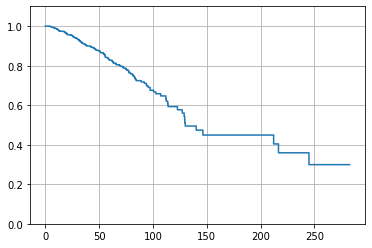

In [2]:
#help(kaplan_meier_estimator)
event = np.asarray(1-df["censorship"]).astype(bool)
time_exit = np.asarray(df["survival_months"])


x_full, y_full = kaplan_meier_estimator(event, time_exit)
plt.step(x_full, y_full, where="post")
plt.ylim(0, 1.1)
plt.grid()
plt.show


In [3]:
from models import AttMil_Survival
from multi_modal_ds import HistGen_Dataset
import torch 
from torch import nn 
from utils import c_index
import numpy as np
import pandas as pd
#load model 
d_hist = 2048
device = 'cuda' if torch.cuda.is_available() else 'cpu'
bins = 4
model = AttMil_Survival(d_hist,bins,device ).to(device)
#load weights 
f_weights = "/work4/seibel/results/alpha0.5hist/AttMil_Survival_nll-alpha0.5-fold5-l1_lambda1e-07.pth"
weights = torch.load(f_weights)['model']
model.load_state_dict(weights)



/home/seibel/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [4]:

f =  f"/nodes/bevog/work4/seibel/data/tcga_brca_trainable{bins}.csv"
df = pd.read_csv(f)
data_path = "/nodes/bevog/work4/seibel/data/TCGA-BRCA-DX-features/tcga_brca_20x_features/pt_files" 
test_ds = HistGen_Dataset(df,data_path,train=False)
test_dataloader = torch.utils.data.DataLoader(test_ds,batch_size=1)

out_all_val =torch.empty(size=(len(test_dataloader),bins),device='cpu')        
l_all_val = torch.empty(size=(len(test_dataloader),),device='cpu').to(torch.int16)
l_cont_all_val = torch.empty(size=(len(test_dataloader),),device='cpu').to(torch.int16)
c_all_val = torch.empty(size=(len(test_dataloader),),device='cpu').to(torch.int16)

model.eval()
with torch.no_grad():
    for  idx,(histo,gen,c,l,l_cont) in enumerate(test_dataloader):
        x = histo.to(device)
        out = model(x)
        out = out.cpu()
        
        out_all_val[idx,:] = out
        l_all_val[idx] = l
        c_all_val[idx] = c
        l_cont_all_val[idx] = l_cont

h = nn.Sigmoid()(out_all_val)
S = torch.cumprod(1-h,dim = -1)
risk = -S.sum(dim=1) ## TODO why is it not 1-S ???




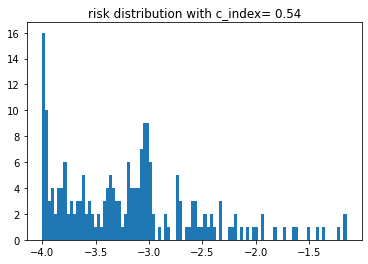

20971

In [5]:
from utils import c_index
import matplotlib.pyplot as plt

c_ind = c_index(out_all_val,c_all_val,l_all_val)
plt.title(f"risk distribution with c_index= {round(c_ind,3)}")
plt.hist(risk.numpy(),bins = 100)
plt.show()
test_ds.gen_depth()

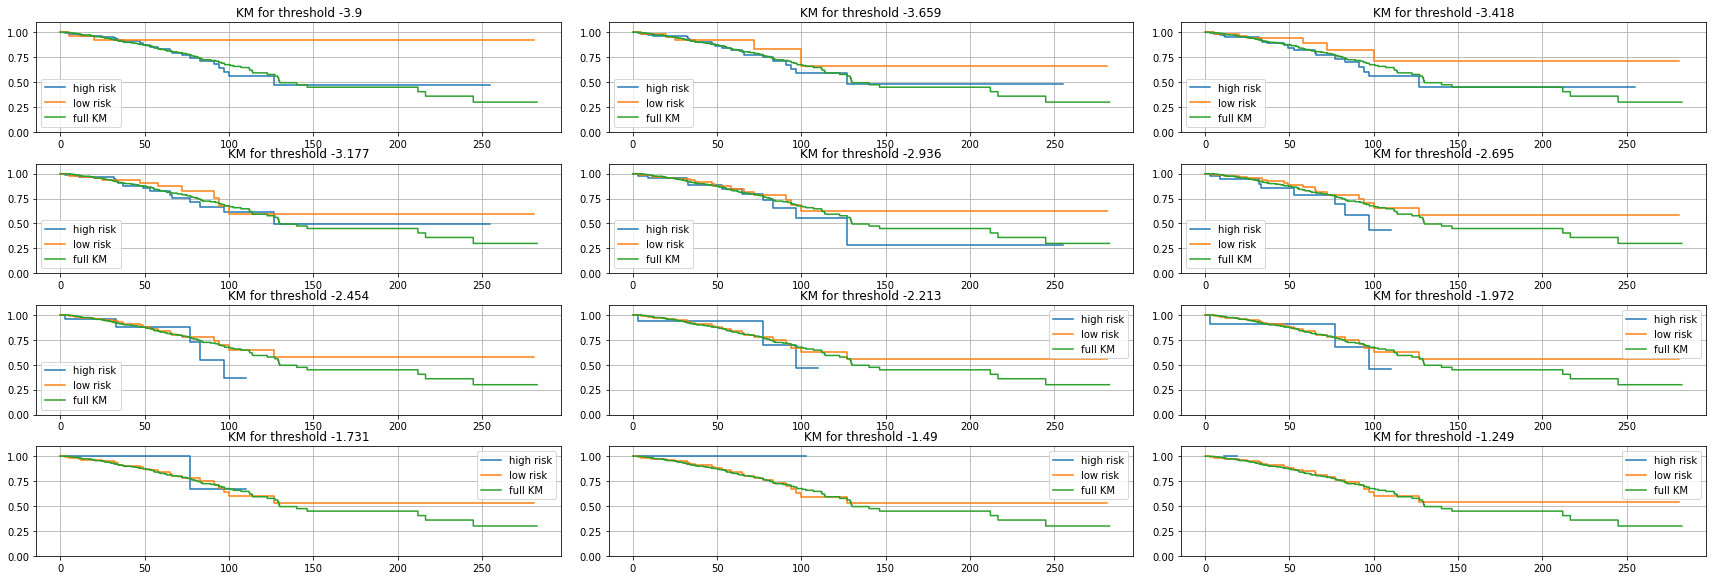

In [6]:
rows = 4 
eps=0.1
threshold = np.linspace(risk.min()+eps,risk.max()-eps,num=12)
fig,ax1 = plt.subplots(rows,len(threshold)//rows,figsize=(24,8))
fig.tight_layout()
for i in range(len(threshold)):
    risk_bool = risk>threshold[i]
    event1 = np.asarray(1-c_all_val[risk_bool]).astype(bool)
    time_exit1 = np.asarray(l_cont_all_val[risk_bool])
    x1, y1 = kaplan_meier_estimator(event1, time_exit1)

    event2 = np.asarray(1-c_all_val[~risk_bool]).astype(bool)
    time_exit2 = np.asarray(l_cont_all_val[~risk_bool])
    x2, y2 = kaplan_meier_estimator(event2, time_exit2)
    
    x_full, y_full = kaplan_meier_estimator(event, time_exit)

    ax1.flatten()[i].set_title(f"KM for threshold {round(threshold[i],3)}")
    ax1.flatten()[i].step(x1, y1, where="post",label="high risk")
    ax1.flatten()[i].step(x2, y2, where="post",label="low risk")
    ax1.flatten()[i].step(x_full, y_full, where="post",label="full KM")
    
    ax1.flatten()[i].set_ylim(0, 1.1)
    ax1.flatten()[i].grid()
    ax1.flatten()[i].legend()


#plt.clf
#plt.title(f"KM for threshold {round(threshold[i])}")
#plt.step(x1, y1, where="post",label="high risk")
#plt.step(x2, y2, where="post",label="low risk")
#plt.ylim(0, 1.1)
#plt.grid()
#plt.legend()
#plt.show

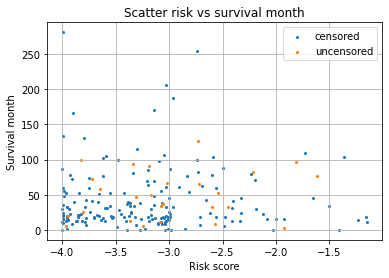

In [7]:
plt.title("Scatter risk vs survival month")
plt.scatter(risk[c_all_val.type(torch.bool)],l_cont_all_val[c_all_val.type(torch.bool)],s = 4,label="censored")
plt.scatter(risk[~(c_all_val.type(torch.bool))],l_cont_all_val[~(c_all_val.type(torch.bool))],s = 4,label="uncensored")
plt.xlabel("Risk score")
plt.ylabel("Survival month")
plt.legend()
plt.grid()

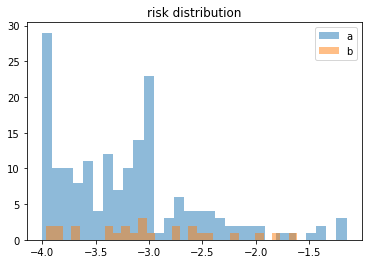

In [8]:
plt.clf()
plt.title(f"risk distribution")
plt.hist(risk[c_all_val.type(torch.bool)].numpy(),bins = 30,alpha=0.5,label="a")
plt.hist(risk[~(c_all_val.type(torch.bool))].numpy(),bins = 30,alpha=0.5,label="b")
plt.legend()
plt.show()

In [30]:
import wandb
import matplotlib.pyplot as plt 
wandb.init(project="MultiModal",entity="tobias-seibel",name="tests")
out_all_val = out_all_val
n_thresholds = 4
nbins = 30
c_all_val = c_all_val
l_cont_all_val = l_cont_all_val 

#risk
def get_risk(out):
    h = nn.Sigmoid()(out)
    S = torch.cumprod(1-h,dim = -1)
    risk = -S.sum(dim=1)
    return risk
risk_all = get_risk(out_all_val)

#thresholds
min,max = risk_all.min(),risk_all.max()
thresholds = torch.linspace(min,max,n_thresholds+2)[1:-1]

#hist 
censored = c_all_val.type(torch.bool)
uncensored = ~c_all_val.type(torch.bool)

x_c1 = torch.histc(risk_all[censored],bins=nbins,min = min , max =max ) 
x1_label = torch.ones_like(x_c1)
x_c2 = torch.histc(risk_all[uncensored],bins=nbins,min = min , max =max ) 
x2_label = torch.zeros_like(x_c2)
x_all = torch.stack((x_c1,x_c2)).T


#table = wandb.Table(data = x_all.tolist(),columns=["censored","uncensored"])
table = wandb.plot.line_series(
          xs =np.linspace(min,max,nbins),
          ys=[x_c1,x_c2],
          keys=["censored", "uncensored"],
          title=f"Histogramm",
          xname="risk")
wandb.log({"custom":table})
#KM

#stepfunction
def stepfunc(x,y,eps=1e-4):
    x = np.stack((x-eps,x),axis=1).flatten()
    y = np.stack((y,y),axis=1).flatten()
    return x[1:].copy(),y[:-1].copy()








for idx,threshold in enumerate(thresholds.tolist()): #thresholds
    x_full, y_full = kaplan_meier_estimator(uncensored.numpy(), l_cont_all_val)

    xlow, ylow = kaplan_meier_estimator(uncensored[risk>threshold].numpy(),
                                l_cont_all_val[risk>threshold].numpy())

    xhigh, yhigh = kaplan_meier_estimator(uncensored[risk<=threshold].numpy(),
                                l_cont_all_val[risk<=threshold].numpy())
    
    xfull, yfull = stepfunc(x_full, y_full)
    xlow, ylow =stepfunc(xlow, ylow)
    xhigh, yhigh =stepfunc(xhigh, yhigh)

    #x,y1,y2,y3 = KM_table(xlow,ylow,xhigh,yhigh,xfull,yfull,)
    lineseries = wandb.plot.line_series(
          xs=[xlow,xhigh,xfull],
          ys=[ylow,yhigh,yfull],
          keys=["lowrisk", "highrisk","fullrisk"],
          title=f"KM Stratification at risk={str(round(threshold,2)).replace('.',',')}",
          xname="time")
    
    wandb.log({f"KM_{idx}" :lineseries})
    

# Log the table to wandb
wandb.log({"line_series": table})


wandb.finish()

In [31]:

def KM_table(xlow,ylow,xhigh,yhigh,xfull,yfull,):
    ### get KM curve on same x values... not needed anymore FML
    low_all = np.stack((xlow,ylow,np.empty_like(ylow)*np.nan,np.empty_like(ylow)*np.nan),1)
    high_all = np.stack((xhigh,np.empty_like(yhigh)*np.nan,yhigh,np.empty_like(yhigh)*np.nan),1)
    full_all = np.stack((xfull,np.empty_like(yfull)*np.nan,np.empty_like(yfull)*np.nan, yfull),1)
    all = np.concatenate((low_all,high_all,full_all),axis=0)

    all = all[all[:, 0].argsort()] # sort by first element 

    for i in range(1,len(all)):
        a = all[i-1,1:] # =:prev-line
        b = all[i,1:]  # =:line
        all[i,1:] = np.where(np.isnan(b),a,b)
        if all[i,0]==all[i-1,0]: #if on same x give info to line, set x of prev-line to nan
            all[i-1,0] = np.nan
            
    all = all[all[:, 0].argsort()]
    all = all[~np.isnan(all[:,0])]
    return all[:,0],all[:,1],all[:,2],all[:,3]  # x, y_low,y_high,y_full



## Final FUnctions for Utils 

In [52]:


def KM_wandb(run,out,c,event_cond,n_thresholds = 4,nbins = 30):
    print("Start Logging KM-Estimators")
    risk = get_risk(out)
    
    #thresholds
    min,max = risk.min(),risk.max()
    thresholds = np.linspace(min,max,n_thresholds+2)[1:-1]
    
    #hist
    censored = c.type(torch.bool)
    uncensored = ~c.type(torch.bool)
    
    hist_censored = torch.histc(risk[censored],bins=nbins,min = min , max =max ) 
    hist_uncensored = torch.histc(risk[uncensored],bins=nbins,min = min , max =max ) 
    
    table = run.plot.line_series(
          xs =np.linspace(min,max,nbins),
          ys=[hist_censored,hist_uncensored],
          keys=["censored", "uncensored"],
          title=f"Histogramm",
          xname="risk")
    run.log({"risk_histogramm":table})
    
    #KaplanMeier Plots
    x_full, y_full = kaplan_meier_estimator(uncensored.numpy(), event_cond)
    xfull, yfull = stepfunc(x_full, y_full)
    for idx,threshold in enumerate(thresholds): 
        xlow, ylow = kaplan_meier_estimator(uncensored[risk>threshold].numpy(),
                                    event_cond[risk>threshold])

        xhigh, yhigh = kaplan_meier_estimator(uncensored[risk<=threshold].numpy(),
                                    event_cond[risk<=threshold])
        
        xlow, ylow =stepfunc(xlow, ylow)
        xhigh, yhigh =stepfunc(xhigh, yhigh)

        
        lineseries = run.plot.line_series(
            xs=[xlow,xhigh,xfull],
            ys=[ylow,yhigh,yfull],
            keys=["lowrisk", "highrisk","fullrisk"],
            title=f"KM Stratification at risk={str(round(threshold,2)).replace('.',',')}",
            xname="time")
        
        run.log({f"KM_{idx}" :lineseries})
    print("Finished logging KM-Estimators")
    
def get_risk(out):
    h = nn.Sigmoid()(out)
    S = torch.cumprod(1-h,dim = -1)
    risk = -S.sum(dim=1)
    return risk

def stepfunc(x,y,eps=1e-4):
    x = np.stack((x-eps,x),axis=1).flatten()
    y = np.stack((y,y),axis=1).flatten()
    return x[1:],y[:-1]

def do_table(x,y,label):
    return [[x[i],y[i],label] for i in range(len(x))]

In [19]:
import wandb
import matplotlib.pyplot as plt 
wandb.init(project="MultiModal",entity="tobias-seibel",name="tests")
out_all_val = out_all_val
n_thresholds = 4
nbins = 30
c_all_val = c_all_val
l_cont_all_val = l_cont_all_val 

#risk
def get_risk(out):
    h = nn.Sigmoid()(out)
    S = torch.cumprod(1-h,dim = -1)
    risk = -S.sum(dim=1)
    return risk
risk_all = get_risk(out_all_val)

#thresholds
min,max = risk_all.min(),risk_all.max()
thresholds = torch.linspace(min,max,n_thresholds+2)[1:-1]

#hist 
censored = c_all_val.type(torch.bool)
uncensored = ~c_all_val.type(torch.bool)

x_c1 = torch.histc(risk_all[censored],bins=nbins,min = min , max =max ).numpy()
x1_label = np.chararray(np.shape(x_c1))
x1_label[:]="censored"
x_c2 = torch.histc(risk_all[uncensored],bins=nbins,min = min , max =max ).numpy() 
x2_label = np.chararray(np.shape(x_c2))
x2_label[:]="uncensored"

x1 = np.stack((np.linspace(min,max,nbins),x_c1,x1_label))
x2 = np.stack((np.linspace(min,max,nbins),x_c2,x2_label))
np.concatenate((x1,x2),dim=1).T

table = wandb.Table(
          data = np.concatenate((x1,x2),dim=1).T,
          columns=["bins", "risk","category"],
          
          

          )
wandb.log({"custom":table})
#KM

wandb.finish()


## Better version for custom plots! 

In [60]:

x = np.linspace(min,max,nbins)
x_c1 = torch.histc(risk_all[censored],bins=nbins,min = min , max =max ).numpy()
x_c2 = torch.histc(risk_all[uncensored],bins=nbins,min = min , max =max ).numpy() 

table_hist = wandb.Table(
          data = do_table(x,x_c1,"censored")+do_table(x,x_c2,"uncensored"),
          columns=["risk", "count","category"],
          )

fields_hist = {"x":"risk","y":"count","groupKeys":"category","title":"Risk Distribution"}
custom_histogram = wandb.plot_table(vega_spec_name="tobias-seibel/risk_distribution",
              data_table=table_hist,
              fields = fields_hist )
              
              
event_cond = l_cont_all_val
threshold = -2
xfull, yfull = kaplan_meier_estimator(uncensored.numpy(), event_cond)

xlow, ylow = kaplan_meier_estimator(uncensored[risk>threshold].numpy(),
                                    event_cond[risk>threshold])

xhigh, yhigh = kaplan_meier_estimator(uncensored[risk<=threshold].numpy(),
                                    event_cond[risk<=threshold])
        


table_KM = wandb.Table(
          data = do_table(xlow,ylow,"low risk group")+do_table(xhigh,yhigh,"risk high group")+do_table(xfull,yfull,"total group"),
          columns=["time","Survival Probability","Group"],)

field_KM = {"x":"time","y":"Survival Probability","groupKeys":"Group"}
custom_KM = wandb.plot_table(vega_spec_name="tobias-seibel/kaplanmeier",
              data_table=table_KM,
              fields = field_KM, 
              string_fields={"title":f"KM Risk Stratification at {round(threshold,2)}"},
              )

wandb.init()

idx = 1 
wandb.log({"Risk Distribution":custom_histogram,"KM{idx}":custom_KM}) #tobias-seibel/risk_distribution # tobias-seibel/kaplanmeier
wandb.finish()


In [62]:
def KM_wandb(run,out,c,event_cond,n_thresholds = 4,nbins = 30):
    print("Start Logging KM-Estimators")
    risk = get_risk(out)
    
    #thresholds
    min,max = risk.min(),risk.max()
    thresholds = np.linspace(min,max,n_thresholds+2)[1:-1]
    
    #hist
    censored = c.type(torch.bool)
    uncensored = ~c.type(torch.bool)
    
    ###wandb histogram
    x = np.linspace(min,max,nbins)
    x_c1 = torch.histc(risk_all[censored],bins=nbins,min = min , max =max ).numpy()
    x_c2 = torch.histc(risk_all[uncensored],bins=nbins,min = min , max =max ).numpy() 

    table_hist = wandb.Table(
            data = do_table(x,x_c1,"censored")+do_table(x,x_c2,"uncensored"),
            columns=["risk", "count","category"],
            )

    fields_hist = {"x":"risk","y":"count","groupKeys":"category","title":"Risk Distribution"}
    custom_histogram = wandb.plot_table(vega_spec_name="tobias-seibel/risk_distribution",
                data_table=table_hist,
                fields = fields_hist )
    
    wandb.log({"Risk Distribution":custom_histogram})
    ###
    
    
    
    
    #KaplanMeier Plots
    xfull, yfull = kaplan_meier_estimator(uncensored.numpy(), event_cond)
    
    for idx,threshold in enumerate(thresholds): 
        xlow, ylow = kaplan_meier_estimator(uncensored[risk>threshold].numpy(),
                                    event_cond[risk>threshold])

        xhigh, yhigh = kaplan_meier_estimator(uncensored[risk<=threshold].numpy(),
                                    event_cond[risk<=threshold])
        
        
        table_KM = wandb.Table(data = do_table(xlow,ylow,"low risk group")+do_table(xhigh,yhigh,"risk high group")+do_table(xfull,yfull,"total group"),
                        columns=["time","Survival Probability","Group"],)

        field_KM = {"x":"time","y":"Survival Probability","groupKeys":"Group"}
        custom_KM = wandb.plot_table(vega_spec_name="tobias-seibel/kaplanmeier",
                    data_table=table_KM,
                    fields = field_KM, 
                    string_fields={"title":f"KM Risk Stratification at {round(threshold,2)}"},
                    )
        run.log({f"KM_{idx}" :custom_KM})
    print("Finished logging KM-Estimators")
    

In [64]:
run = wandb.init()
KM_wandb(run,out_all_val,c_all_val,l_cont_all_val,n_thresholds = 4,nbins = 30)
run.finish()

Start Logging KM-Estimators
Finished logging KM-Estimators


# Transformer 


In [13]:
import torch
from torch import nn
from utils import *
class Classifier_Head(nn.Module):
    def __init__(self,outsize,d_hidden=256,t_bins=4):
        super(Classifier_Head,self).__init__()

        self.linear1 = nn.Linear(outsize,d_hidden)
        torch.nn.init.kaiming_normal_(self.linear1.weight)
        self.activ1 = nn.ReLU()
        self.linear2  = nn.Linear(d_hidden,d_hidden)
        torch.nn.init.kaiming_normal_(self.linear2.weight)
        self.activ2 = nn.ReLU()
        self.fc = nn.Linear(d_hidden,t_bins) # TODO test add layer
    def forward(self,x):
        x = torch.flatten(x,start_dim=1)
        x = self.activ1(self.linear1(x))
        x = self.activ2(self.linear2(x))
        return self.fc(x)
    
    
class TransformerMil_Survival(nn.Module):
  def __init__(self,d_transformer,d_seq,bins):
    super(TransformerMil_Survival,self).__init__()
    
    self.lin_embedder1 = nn.Linear(d_seq,d_transformer)
    self.Encoder = torch.nn.TransformerEncoder(nn.TransformerEncoderLayer(d_transformer,
                                                                     nhead=8,dropout=0.1,activation=nn.GELU(),batch_first=True)
                                          ,num_layers=2)
    self.lin_embedder2 = nn.Linear(d_transformer,d_seq//2)
    self.Classifier_Head = Classifier_Head(outsize = d_seq//2,d_hidden=256,t_bins=bins)
  def forward(self,x):
    
    x = self.lin_embedder1(x)
    x = self.Encoder(x)
    out = x.mean(dim=-2)
    out = self.lin_embedder2(out)
    return self.Classifier_Head(out)


In [14]:
device = "cuda"
bins = 4
model = TransformerNet(d_transformer=1024,d_seq=2048,bins=bins)
model.to(device)


criterion = Survival_Loss(0.25) 
optimizer = torch.optim.Adam(model.parameters(),lr=0.00003,betas=[0.9,0.999],weight_decay=1e-5,)

In [41]:
nseq = 500
B=10
dims = 2048

x = torch.rand(size=(B,nseq,dims)).to(device)
l = torch.randint(low=0, high=bins, size=(B,)).to(device)
c = torch.randint(low=0, high=2, size=(B,)).to(device)  ## Groundtruth boolean information wether the the patient is censored  c = 1 or uncensored  

out = model(x)
loss = criterion(out,c,l)
loss.backward()